In [4]:
import numpy as np
import matplotlib.pyplot as plt


In [5]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.6 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

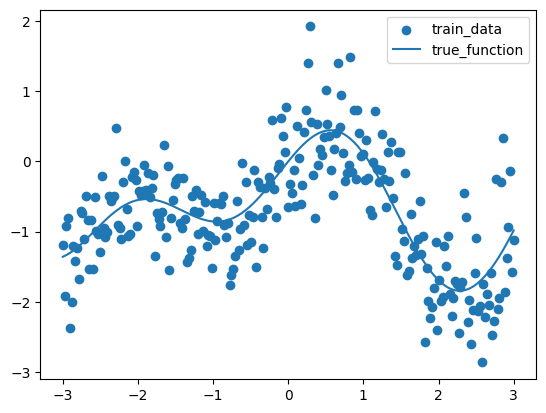

In [6]:
rng = np.random.default_rng(42)

N = 255
x = np.linspace(-3, 3, N)

sigma = 0.55
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 14
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [7]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [8]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [9]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

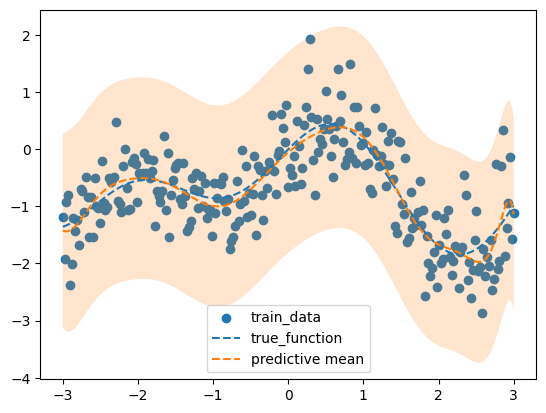

In [10]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

Оптимальная λ (lamb): 0.0110
Максимальное log-evidence: -279.3292


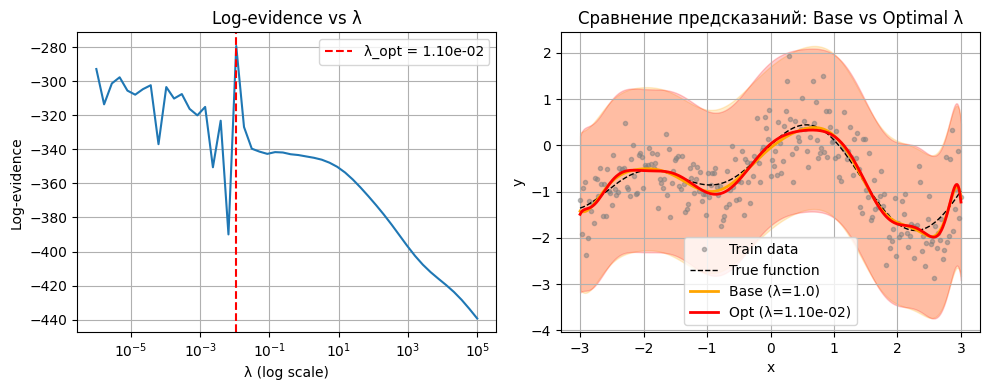

In [14]:

def log_evidence(lamb, X, y, alpha):
    '''
    Формула: log p(y | X, alpha, lamb) = -N/2 log(2π) - 1/2 log|C| - 1/2 y^T C^{-1} y
    Где C = (1/alpha) I + (1/lamb) X X^T
    '''
    N = len(y)
    lamb_safe = np.maximum(lamb, 1e-10)
    C = (1.0 / alpha) * np.eye(N) + (1.0 / lamb_safe) * (X @ X.T)
    log_det_C, _ = np.linalg.slogdet(C)  # log|C|
    C_inv_y = np.linalg.solve(C, y)
    quad_term = 0.5 * np.dot(y.T, C_inv_y)
    log_ev = - (N / 2) * np.log(2 * np.pi) - 0.5 * log_det_C - quad_term
    return log_ev

#  λ 
lambdas = np.logspace(-6, 5, 50)
log_evidences = np.array([log_evidence(lamb, X, y, alpha) for lamb in lambdas])

# Оптимальная λ
lamb_opt_idx = np.argmax(log_evidences)
lamb_opt = lambdas[lamb_opt_idx]
print(f"Оптимальная λ (lamb): {lamb_opt:.4f}")
print(f"Максимальное log-evidence: {log_evidences[lamb_opt_idx]:.4f}")

# График 1: log-evidence vs log(λ)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.semilogx(lambdas, log_evidences)
plt.axvline(lamb_opt, color='r', linestyle='--', label=f'λ_opt = {lamb_opt:.2e}')
plt.xlabel('λ (log scale)')
plt.ylabel('Log-evidence')
plt.title('Log-evidence vs λ')
plt.legend()
plt.grid(True)


def plot_predictions(lamb, title, color='b'):
    M = X.shape[1]
    posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)
    posterior_cov = np.linalg.inv(posterior_cov_inv)
    mean_w = alpha * posterior_cov @ (X.T @ y)
    
    x_new = np.linspace(-3, 3, 400)
    X_new = make_poly_features(x_new, degree)
    mean_pred = X_new @ mean_w
    var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
    std_pred = np.sqrt(var_pred)
    
    plt.scatter(x, y, alpha=0.5, label='Train data', color='gray')
    plt.plot(x_new, f_true(x_new), 'k--', label='True function')
    plt.plot(x_new, mean_pred, color=color, linestyle='-', linewidth=2, label=f'Pred mean (λ={lamb:.2e})')
    plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, 
                     color=color, alpha=0.2, label='±2σ')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True)

# График 2: Сравнение базовой (λ=1.0) и оптимальной модели
plt.subplot(1, 2, 2)
plt.plot(x, y, 'o', alpha=0.5, markersize=3, color='gray', label='Train data')  
plt.plot(x_new, f_true(x_new), 'k--', linewidth=1, label='True function')  

# λ=1.0
plot_base = lambda: plot_predictions(1.0, '', 'orange')  
M = X.shape[1]
posterior_cov_inv_base = 1.0 * np.eye(M) + alpha * (X.T @ X)
posterior_cov_base = np.linalg.inv(posterior_cov_inv_base)
mean_w_base = alpha * posterior_cov_base @ (X.T @ y)
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)
mean_pred_base = X_new @ mean_w_base
var_pred_base = 1.0 / alpha + np.sum(X_new @ posterior_cov_base @ X_new.T, axis=1)
std_pred_base = np.sqrt(var_pred_base)
plt.plot(x_new, mean_pred_base, 'orange', linestyle='-', linewidth=2, label=f'Base (λ=1.0)')
plt.fill_between(x_new, mean_pred_base - 2 * std_pred_base, mean_pred_base + 2 * std_pred_base, 
                 color='orange', alpha=0.2)

# Оптимальная 
posterior_cov_inv_opt = lamb_opt * np.eye(M) + alpha * (X.T @ X)
posterior_cov_opt = np.linalg.inv(posterior_cov_inv_opt)
mean_w_opt = alpha * posterior_cov_opt @ (X.T @ y)
mean_pred_opt = X_new @ mean_w_opt
var_pred_opt = 1.0 / alpha + np.sum(X_new @ posterior_cov_opt @ X_new.T, axis=1)
std_pred_opt = np.sqrt(var_pred_opt)
plt.plot(x_new, mean_pred_opt, 'r', linestyle='-', linewidth=2, label=f'Opt (λ={lamb_opt:.2e})')
plt.fill_between(x_new, mean_pred_opt - 2 * std_pred_opt, mean_pred_opt + 2 * std_pred_opt, 
                 color='red', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение предсказаний: Base vs Optimal λ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()